Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.65MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training model: Base - Parameters: 421642
Epoch [1/5] - Accuracy: 69.07%
Epoch [2/5] - Accuracy: 85.65%
Epoch [3/5] - Accuracy: 90.02%
Epoch [4/5] - Accuracy: 91.57%
Epoch [5/5] - Accuracy: 92.40%
Training model: Mod1 - Parameters: 105866
Epoch [1/5] - Accuracy: 69.10%
Epoch [2/5] - Accuracy: 86.08%
Epoch [3/5] - Accuracy: 88.96%
Epoch [4/5] - Accuracy: 90.51%
Epoch [5/5] - Accuracy: 91.40%
Training model: Mod2 - Parameters: 26698
Epoch [1/5] - Accuracy: 25.27%
Epoch [2/5] - Accuracy: 67.16%
Epoch [3/5] - Accuracy: 82.92%
Epoch [4/5] - Accuracy: 88.26%
Epoch [5/5] - Accuracy: 89.90%
Training model: Mod3 - Parameters: 6794
Epoch [1/5] - Accuracy: 13.65%
Epoch [2/5] - Accuracy: 34.62%
Epoch [3/5] - Accuracy: 56.16%
Epoch [4/5] - Accuracy: 76.41%
Epoch [5/5] - Accuracy: 82.93%

Final Results:
Base: Params = 421642, Param Drop = 0.00%, Accuracy = 92.40%
Mod1: Params = 105866, Param Drop = 74.89%, Accuracy = 91.40%
M

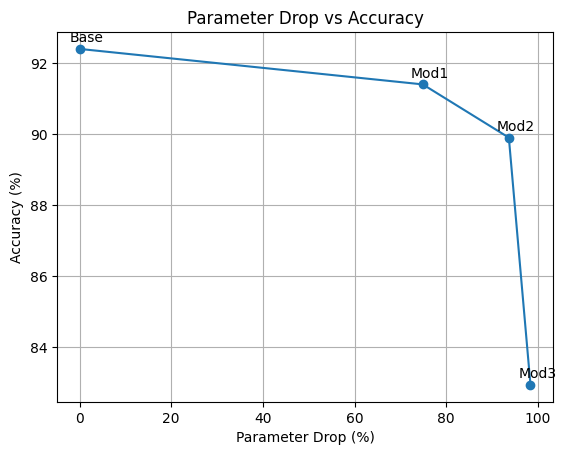

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

batch_size = 64
learning_rate = 0.001
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self, filters1=32, filters2=64, linear1=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, filters1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(filters1, filters2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1)
        )
        self.classification_head = nn.Sequential(
            nn.Linear((filters2 * 7 * 7), linear1),
            nn.ReLU(),
            nn.Linear(linear1, 10)
        )
    
    def forward(self, x):
        return self.classification_head(self.net(x))


def train_evaluate(model, train_loader, test_loader, learning_rate, epochs, device):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            correct = sum((model(images.to(device)).argmax(1) == labels.to(device)).sum().item() for images, labels in test_loader)
            accuracy = 100 * correct / len(test_loader.dataset)
            print(f'Epoch [{epoch+1}/{epochs}] - Accuracy: {accuracy:.2f}%')
        model.train()
    return accuracy


def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model_configs = {   
    "Base": (32, 64, 128),
    "Mod1": (16, 32, 64),
    "Mod2": (8, 16, 32),
    "Mod3": (4, 8, 16),
}

results = {}
base_params = None  
for name, (filters1, filters2, linear1) in model_configs.items():
    model = CNN(filters1, filters2, linear1).to(device)
    params = count_parameters(model)
    print(f'Training model: {name} - Parameters: {params}')
    accuracy = train_evaluate(model, train_loader, test_loader, learning_rate, epochs, device)
    results[name] = {"params": params, "accuracy": accuracy}
    if name == "Base":
        base_params = params

param_drops = {name: (1 - (data["params"] / base_params)) * 100 if base_params else 0 for name, data in results.items()}

print("\nFinal Results:")
for name, data in results.items():
    print(f"{name}: Params = {data['params']}, Param Drop = {param_drops[name]:.2f}%, Accuracy = {data['accuracy']:.2f}%")

names = list(results.keys())
accuracies = [results[name]["accuracy"] for name in names]
drops = [param_drops[name] for name in names]

plt.plot(drops, accuracies, marker='o')
plt.xlabel("Parameter Drop (%)")
plt.ylabel("Accuracy (%)")
plt.title("Parameter Drop vs Accuracy")
plt.grid(True)
for i, name in enumerate(names):
    plt.annotate(name, (drops[i], accuracies[i]), textcoords="offset points", xytext=(5,5), ha='center')
plt.show()
